Motivated by Gregory Smith's web scrape of VGChartz Video Games Sales, this data set simply extends the number of variables with another web scrape from Metacritic. Unfortunately, there are missing observations as Metacritic only covers a subset of the platforms. Also, a game may not have all the observations of the additional variables discussed below. Complete cases are ~ 6,900

## Content 

Alongside the fields: Name, Platform, Year_of_Release, Genre, Publisher, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales, we have:

- Critic_score - Aggregate score compiled by Metacritic staff
- Critic_count - The number of critics used in coming up with the Critic_score
- User_score - Score by Metacritic's subscribers
- User_count - Number of users who gave the user_score
- Developer - Party responsible for creating the game
- Rating - The ESRB ratings

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn 
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100) 

# Read data

In [2]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


# Data pre-processing & EDA

In [4]:
df.shape

(16719, 16)

There are 16 columns with 16,719 rows in this dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [6]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


The target variable is the Global_Sales (which we want to predict). First we will see how the Global_Sales is distributed.

As a general rule of thumb: If skewness is less than -1 or greater than 1, the distribution is highly skewed. If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

Skewness: 17.38
Kurtosis: 604.10


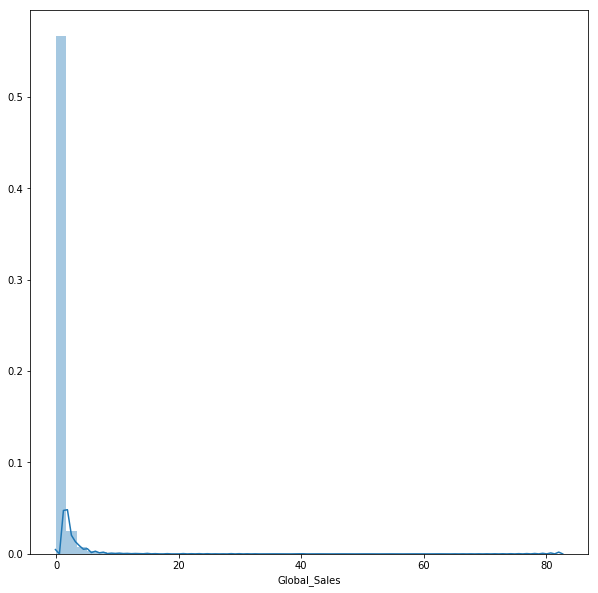

In [7]:
plt.figure(figsize=(10,10))
sns.distplot(df.Global_Sales)
#skewness and kurtosis
print("Skewness: %0.2f" % df['Global_Sales'].skew())
print("Kurtosis: %0.2f" % df['Global_Sales'].kurt())

As we can see, the Global_Sales has a very long tail (outliers). Therefore, we first have to log-transform the Global_Sales.

We will use the log(x+1) tranformation.

In [8]:
df['Global_Sales_Log'] = np.log1p(df['Global_Sales'])

Skewness: 2.76
Kurtosis: 10.71


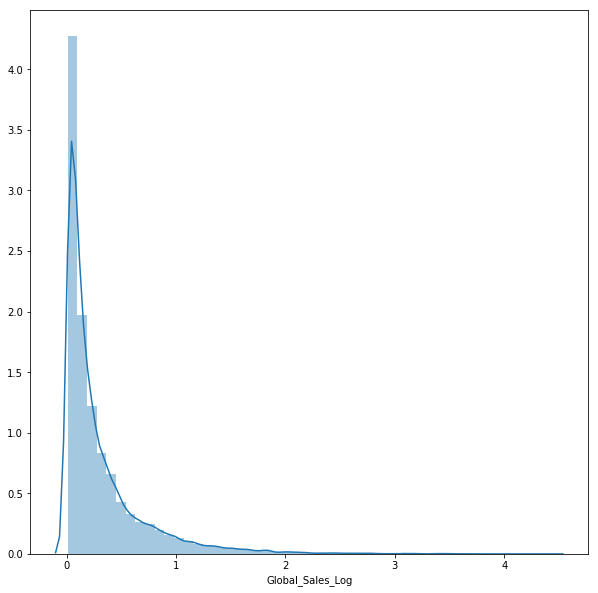

In [9]:
plt.figure(figsize=(10,10))
sns.distplot(df.Global_Sales_Log)
#skewness and kurtosis
print("Skewness: %0.2f" % df['Global_Sales_Log'].skew())
print("Kurtosis: %0.2f" % df['Global_Sales_Log'].kurt())

We will do the same for NA_Sales, EU_Sales, JP_Sales, Other_Sales.

In [10]:
df['NA_Sales_Log'] = np.log1p(df['NA_Sales'])
df['EU_Sales_Log'] = np.log1p(df['EU_Sales'])
df['JP_Sales_Log'] = np.log1p(df['JP_Sales'])
df['Other_Sales_Log'] = np.log1p(df['Other_Sales'])

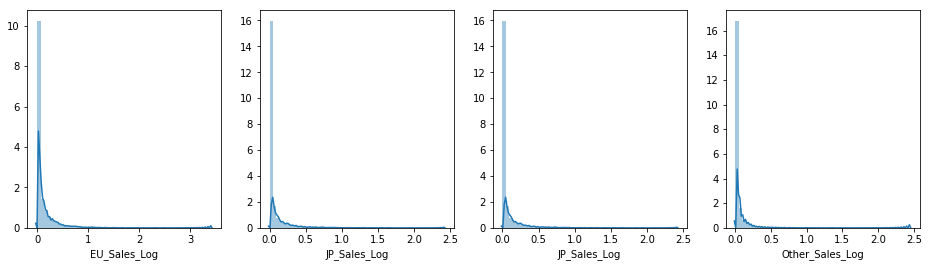

In [11]:
fig, ax =plt.subplots(1,4, figsize=(16,4))
sns.distplot(df['EU_Sales_Log'], ax=ax[0])
sns.distplot(df['JP_Sales_Log'], ax=ax[1])
sns.distplot(df['JP_Sales_Log'], ax=ax[2])
sns.distplot(df['Other_Sales_Log'], ax=ax[3])
fig.show()


## Missing values 

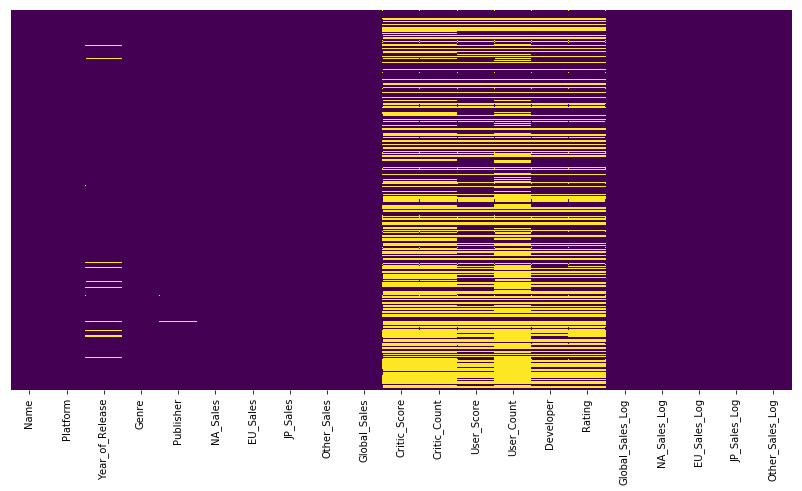

In [12]:
plt.figure(figsize=(14,7))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [13]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Name                  2
Year_of_Release     269
Genre                 2
Publisher            54
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [14]:
df[df.Name.isnull()]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Global_Sales_Log,NA_Sales_Log,EU_Sales_Log,JP_Sales_Log,Other_Sales_Log
659,NaN,GEN,1993.0,NaN,Acclaim Entertainment,1.78,0.53,0.00,0.08,2.39,NaN,NaN,NaN,NaN,NaN,NaN,1.220830,1.022451,0.425268,0.000000,0.076961
14246,NaN,GEN,1993.0,NaN,Acclaim Entertainment,0.00,0.00,0.03,0.00,0.03,NaN,NaN,NaN,NaN,NaN,NaN,0.029559,0.000000,0.000000,0.029559,0.000000


The two rows with missing game names has a lot of missing values. Therefore, we will drop these rows by index.

In [15]:
df.drop(index=[659,14246],inplace=True)

#### Filling missing years of release 

There are 269 rows which have missing values for year of release. We will fill those values by looking at the platform and use the median value of that platform. For example, if the platform is PS2, it will be given the value 2005.

First, we will transform Year_of_Release from float to integer

In [16]:
df[df.Year_of_Release.isnull()]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Global_Sales_Log,NA_Sales_Log,EU_Sales_Log,JP_Sales_Log,Other_Sales_Log
183,Madden NFL 2004,PS2,NaN,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23,94.0,29.0,8.5,140.0,EA Tiburon,E,1.829376,1.660131,0.231112,0.009950,0.536493
377,FIFA Soccer 2004,PS2,NaN,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49,84.0,20.0,6.4,76.0,EA Canada,E,1.501853,0.463734,1.211941,0.039221,0.412110
456,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,1.80,0.97,0.00,0.29,3.06,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,1.401183,1.029619,0.678034,0.000000,0.254642
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,NaN,1.57,1.02,0.00,0.41,3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.386294,0.943906,0.703098,0.000000,0.343590
609,Space Invaders,2600,NaN,Shooter,Atari,2.36,0.14,0.00,0.03,2.53,NaN,NaN,NaN,NaN,NaN,NaN,1.261298,1.211941,0.131028,0.000000,0.029559
627,Rock Band,X360,NaN,Misc,Electronic Arts,1.93,0.33,0.00,0.21,2.47,92.0,72.0,8.2,178.0,Harmonix Music Systems,T,1.244155,1.075002,0.285179,0.000000,0.190620
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,Konami Digital Entertainment,2.15,0.18,0.00,0.07,2.39,73.0,4.0,tbd,NaN,Konami Computer Entertainment Hawaii,E,1.220830,1.147402,0.165514,0.000000,0.067659
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,1.51,0.61,0.00,0.21,2.34,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,1.205971,0.920283,0.476234,0.000000,0.190620
719,Call of Duty 3,Wii,NaN,Shooter,Activision,1.17,0.84,0.00,0.23,2.24,69.0,42.0,6.7,61.0,Exakt,T,1.175573,0.774727,0.609766,0.000000,0.207014
805,Rock Band,Wii,NaN,Misc,MTV Games,1.33,0.56,0.00,0.20,2.08,80.0,21.0,6.3,37.0,Harmonix Music Systems,T,1.124930,0.845868,0.444686,0.000000,0.182322


First we fill NaN values with 0 to create a function.

In [17]:
df.Year_of_Release = df.Year_of_Release.fillna(0)

Now, we get all the unique values of platforms where year of release is empty. 

In [18]:
df[df['Year_of_Release']==0].Platform.unique()

array(['PS2', 'Wii', '2600', 'X360', 'GBA', 'PC', 'PS3', 'PS', 'PSP',
       'XB', 'GB', 'DS', 'GC', '3DS', 'N64', 'PSV'], dtype=object)

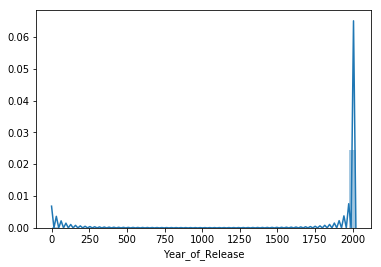

In [19]:
sns.distplot(df.Year_of_Release)

We will create variables of all the median values of the years of the platforms.

In [20]:
PS2_median = df[df['Platform'] == 'PS2']['Year_of_Release'].median()
Wii_median = df[df['Platform'] == 'Wii']['Year_of_Release'].median()
x2600median = df[df['Platform'] == '2600']['Year_of_Release'].median()
X360_median = df[df['Platform'] == 'X360']['Year_of_Release'].median()
GBA_median = df[df['Platform'] == 'GBA']['Year_of_Release'].median()
PC_median = df[df['Platform'] == 'PC']['Year_of_Release'].median()
PS3_median = df[df['Platform'] == 'PS3']['Year_of_Release'].median()
PS_median = df[df['Platform'] == 'PS']['Year_of_Release'].median()
PSP_median = df[df['Platform'] == 'PSP']['Year_of_Release'].median()
XB_median = df[df['Platform'] == 'XB']['Year_of_Release'].median()
GB_median = df[df['Platform'] == 'GB']['Year_of_Release'].median()
DS_median = df[df['Platform'] == 'DS']['Year_of_Release'].median()
x3DS_median = df[df['Platform'] == '3DS']['Year_of_Release'].median()
N64_median = df[df['Platform'] == 'N64']['Year_of_Release'].median()
PSV_median = df[df['Platform'] == 'PSV']['Year_of_Release'].median()
GC_median = df[df['Platform'] == 'GC']['Year_of_Release'].median()

In [21]:
# Function that returns the median of the platform if year = 0. Else it returns the year.
def year_filler(x):
    
    if x.Year_of_Release == 0:
        if x.Platform == 'PS2':
            return PS2_median
        elif x.Platform == 'Wii':
            return Wii_median
        elif x.Platform == '2600':
            return x2600median
        elif x.Platform == 'X360':
            return X360_median
        elif x.Platform == 'GBA':
            return GBA_median
        elif x.Platform == 'PC':
            return PC_median
        elif x.Platform == 'PS3':
            return PS3_median
        elif x.Platform == 'PS':
            return PS_median
        elif x.Platform == 'PSP':
            return PSP_median
        elif x.Platform == 'XB':
            return XB_median
        elif x.Platform == 'GB':
            return GB_median
        elif x.Platform == 'DS':
            return DS_median
        elif x.Platform == '3DS':
            return x3DS_median
        elif x.Platform == 'N64':
            return N64_median
        elif x.Platform == 'PSV':
            return PSV_median
        elif x.Platform == 'GC':
            return GC_median
        else:
            return 1900
    else:
        return x.Year_of_Release

In [22]:
# apply function to replace values
df.Year_of_Release = df.apply(year_filler, axis=1)

All the years are now filled based on the year_filler function. 

In [23]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Publisher         54
Critic_Score    8580
Critic_Count    8580
User_Score      6702
User_Count      9127
Developer       6621
Rating          6767
dtype: int64

Some rows are have missing values for Publisher. We will fill the missing values of Publisher with 'Unknown'.

In [24]:
df['Publisher'].fillna(value='Unknown', inplace=True)

For Critic_Score, Critic_Count, User_Score, User_Count, Developer and Rating, almost half of the rows have missing values. 
25 to 30% is the maximum missing values are allowed. 

However, we will first try to fill those values with the median and see how our ML models perform.

In [25]:
columns = df.columns
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)

                       column_name  percent_missing
Name                          Name         0.000000
Platform                  Platform         0.000000
Year_of_Release    Year_of_Release         0.000000
Genre                        Genre         0.000000
Publisher                Publisher         0.000000
NA_Sales                  NA_Sales         0.000000
EU_Sales                  EU_Sales         0.000000
JP_Sales                  JP_Sales         0.000000
Other_Sales            Other_Sales         0.000000
Global_Sales          Global_Sales         0.000000
Critic_Score          Critic_Score        51.324999
Critic_Count          Critic_Count        51.324999
User_Score              User_Score        40.090925
User_Count              User_Count        54.597117
Developer                Developer        39.606389
Rating                      Rating        40.479751
Global_Sales_Log  Global_Sales_Log         0.000000
NA_Sales_Log          NA_Sales_Log         0.000000
EU_Sales_Log

We will start by filling the missing values of Critic_Score and Critic_Count.

In [26]:
df.Critic_Score = df.Critic_Score.fillna(df.Critic_Score.median())

In [27]:
df.Critic_Count = df.Critic_Count.fillna(df.Critic_Count.median())

In [28]:
columns = df.columns
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)

                       column_name  percent_missing
Name                          Name         0.000000
Platform                  Platform         0.000000
Year_of_Release    Year_of_Release         0.000000
Genre                        Genre         0.000000
Publisher                Publisher         0.000000
NA_Sales                  NA_Sales         0.000000
EU_Sales                  EU_Sales         0.000000
JP_Sales                  JP_Sales         0.000000
Other_Sales            Other_Sales         0.000000
Global_Sales          Global_Sales         0.000000
Critic_Score          Critic_Score         0.000000
Critic_Count          Critic_Count         0.000000
User_Score              User_Score        40.090925
User_Count              User_Count        54.597117
Developer                Developer        39.606389
Rating                      Rating        40.479751
Global_Sales_Log  Global_Sales_Log         0.000000
NA_Sales_Log          NA_Sales_Log         0.000000
EU_Sales_Log

We will start by filling the missing values of Critic_Score and Critic_Count.

Because Critic_Score has NaN values, we will first fill those NaN values with 0.

In [29]:
df.User_Score = df.User_Score.fillna(0)

Some values of Critic_Score have the value'tbd'. These values need to be replaces with 100. Because if they are replaced with 0, the median will possibly become 0 as well.

In [30]:
df.User_Score.replace(to_replace='tbd',value=100,inplace=True)

Now we will replace the 0 and 100 values by the median.

In [31]:
df.replace({'User_Score' : { 0 : 6.2, 100 : 6.2}},inplace=True)

We will do the same for User_Count

In [32]:
df.User_Count = df.User_Count.fillna(df.User_Count.median())

Replace the missing values of Rating with Unknown.

In [33]:
df.Rating.fillna('Unknown',inplace=True)

Because Developer has too many unique values, we will drop this column.

In [34]:
df.drop('Developer',axis=1,inplace=True)

----------------------------------------------------------------------------

In this section, we will cluster the publishers into a top 10.

In [35]:
values_publishers = df['Publisher'].value_counts()[:10].keys().tolist()
counts_publishers = df['Publisher'].value_counts()[:10].tolist()

In [36]:
# Function that returns the value 'Other' for every publisher other than in the top_ten list
def publisher_other(x):
    if x.Publisher in values_publishers:
        return x.Publisher
    else:
        return 'Other'

In [37]:
# apply function to replace values with 'Other'
df.Publisher = df.apply(publisher_other, axis=1)

In [38]:
columns = df.columns
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)

                       column_name  percent_missing
Name                          Name              0.0
Platform                  Platform              0.0
Year_of_Release    Year_of_Release              0.0
Genre                        Genre              0.0
Publisher                Publisher              0.0
NA_Sales                  NA_Sales              0.0
EU_Sales                  EU_Sales              0.0
JP_Sales                  JP_Sales              0.0
Other_Sales            Other_Sales              0.0
Global_Sales          Global_Sales              0.0
Critic_Score          Critic_Score              0.0
Critic_Count          Critic_Count              0.0
User_Score              User_Score              0.0
User_Count              User_Count              0.0
Rating                      Rating              0.0
Global_Sales_Log  Global_Sales_Log              0.0
NA_Sales_Log          NA_Sales_Log              0.0
EU_Sales_Log          EU_Sales_Log              0.0
JP_Sales_Log

## Remove outliers 

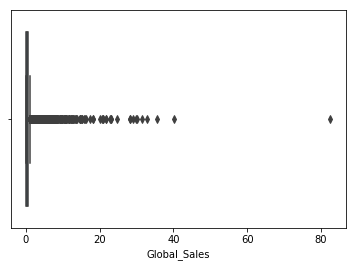

In [39]:
sns.boxplot(df.Global_Sales)

There is one big outlier, which has over 80 million in sales. In order to create a good ML model, we will remove this outlier.

In [40]:
df.drop(index=[0], inplace=True)

### Transform datatypes 

In [41]:
# Transform year from float to integer
df['Year_of_Release'] = df.Year_of_Release.astype(int)

# Transform Critic_Score from float to integer
df['Critic_Score'] = df.Critic_Score.astype(int)

# Transform Critic_Count from float to integer
df['Critic_Count'] = df.Critic_Count.astype(int)

# Transform User_Count from float to integer
df['User_Count'] = df.User_Count.astype(int)

In [42]:
# Transform User_Score to int
df.User_Score = pd.to_numeric(df.User_Score, errors='coerce')

## Data visualization 

We will analyze the following questions:

- Which genre has the highest global sales?
- Which are the most common genres?
- How is the global sales distributed among genres?
- Which platform has the highest global sales, and has Playstation, XBOX and Nintendo improved throughout the versions?
- Which continent has the most game sales?
- Is there a trend throughout the years and the global sales?
- Are children games sold better than adult games?
- Is there a correlation between the numerical features (critic score and user score) and the Global sales?

### Which genre has the highest global sales? 

In [43]:
df.groupby('Genre')['Global_Sales'].max().sort_values(ascending=False)

Genre
Platform        40.24
Racing          35.52
Sports          32.77
Role-Playing    31.37
Puzzle          30.26
Misc            28.92
Shooter         28.31
Simulation      24.67
Action          21.04
Fighting        12.84
Adventure       11.18
Strategy         5.45
Name: Global_Sales, dtype: float64

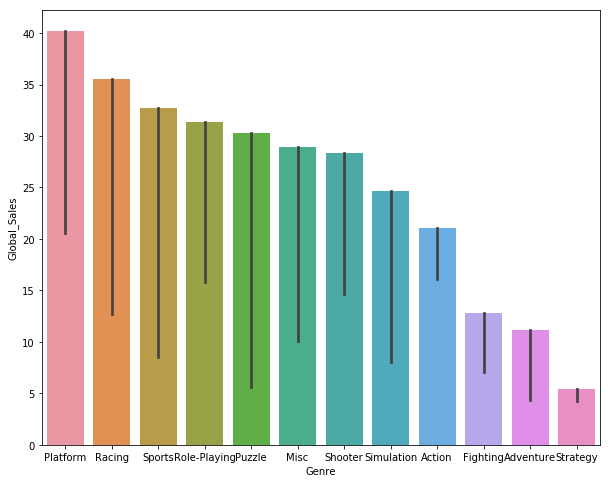

In [44]:
plt.figure(figsize=(10,8))
sns.barplot(x=df.Genre,y=df.Global_Sales, estimator=np.max)

We can see that the best sold game is a Platform game, followed by a Racing game and SportsRole game.

Now we will analyze which Genre has the best Global Sales overall, i.e. on average.

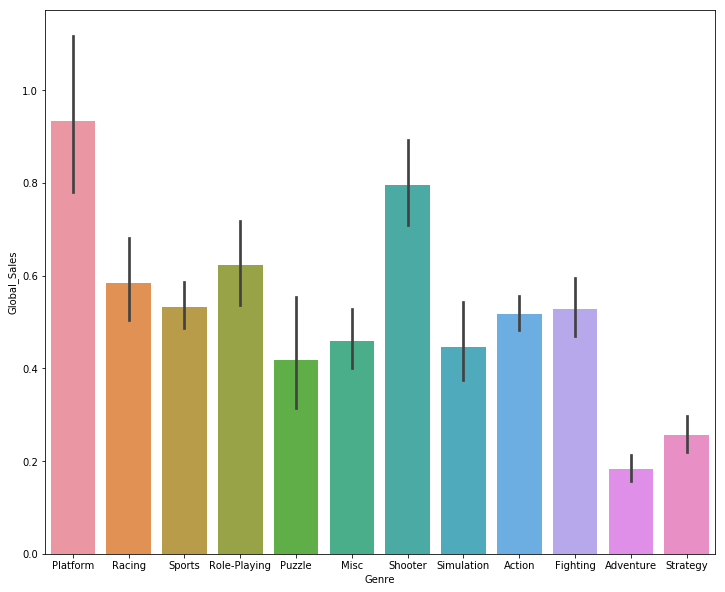

In [45]:
plt.figure(figsize=(12,10))
sns.barplot(x=df.Genre,y=df.Global_Sales, estimator=np.mean)

On average, the platform genre has the highest global sales, followed by shooter games and role-playing games.

We can conclude that Genre has a strong influence on the Global Sales.

### Most common genres

In [46]:
df.Genre.value_counts()

Action          3370
Sports          2347
Misc            1750
Role-Playing    1500
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       874
Fighting         849
Strategy         683
Puzzle           580
Name: Genre, dtype: int64

In [47]:
from wordcloud import WordCloud

In [48]:
# Create a list of word

genre_list = list(df.Genre.values)

In [49]:
text = ' '.join(genre_list)

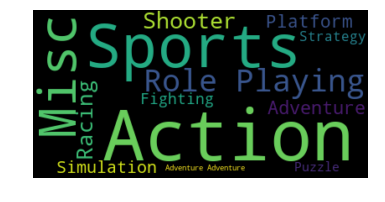

In [50]:
# Create the wordcloud object
wordcloud = WordCloud(width=400, height=200, margin=2).generate(text)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### Which platform has the highest global sales, and has Playstation, XBOX and Nintendo improved throughout the versions?

In [51]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Global_Sales_Log,NA_Sales_Log,EU_Sales_Log,JP_Sales_Log,Other_Sales_Log
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,71,21,6.2,24,Unknown,3.719409,3.403860,1.521699,2.055405,0.570980
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82,73,8.3,709,E,3.597860,2.814210,2.621766,1.566530,1.456287
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80,73,8.0,192,E,3.519573,2.810005,2.479056,1.453953,1.373716
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,71,21,6.2,24,Unknown,3.477232,2.507157,2.291524,2.417698,0.693147
5,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,71,21,6.2,24,Unknown,3.442339,3.186353,1.181727,1.652497,0.457425


In [52]:
# Trendline (y=Global sales, x=Years) of all the Playstation versions and total global sales.

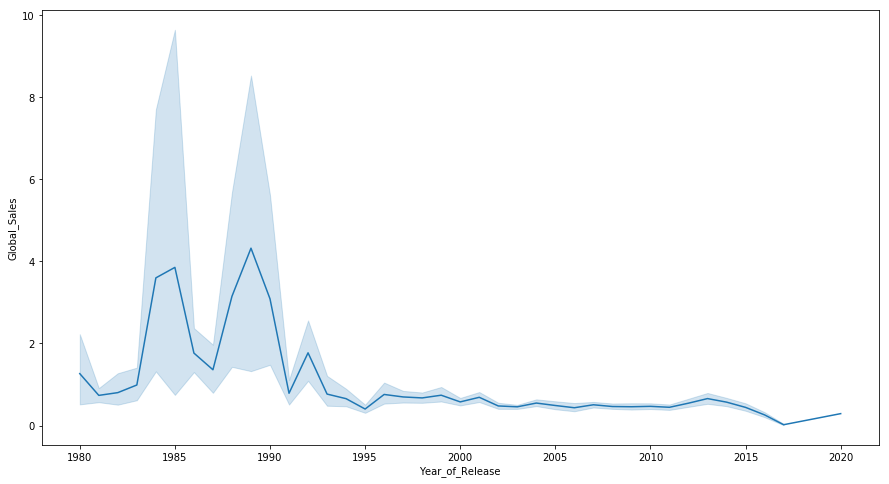

In [53]:
plt.figure(figsize=(15,8))
sns.lineplot(x='Year_of_Release',y='Global_Sales',data=df)

We can see from the trendline, that on average the gaming business was booming between 1983 and started to decline in 1988. Since then, the gaming global sales is in an equilibrium.

However, it is also interesting to see how the highest global sales has evolved throughout the years.

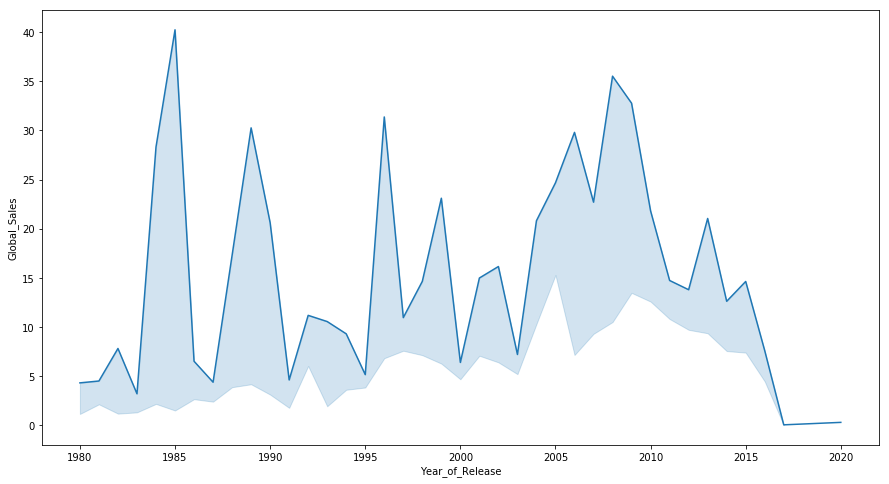

In [54]:
plt.figure(figsize=(15,8))
sns.lineplot(x='Year_of_Release',y='Global_Sales',data=df, estimator=np.max)

As can be seen from the lineplot, it seems that almost every two years there is a hit, with a 'bad' year in between.

Now we will plot the different platforms throughout the years. First we have to cluster the different platforms.

In [55]:
df.Platform.unique()

array(['NES', 'Wii', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [56]:
Playstation_list = ['PS3', 'PS2','PS4','PS']
XBOX_list = ['X360', 'XB','XOne']
Nintendo_list = ['NES', 'Wii','GC','SNES','N64','WiiU']

In [57]:
# Create a list to store the data
Console_cluster = []

# For each row in the column,
for row in df['Platform']:
    # if in list of Playstation
    if row in Playstation_list:
        # Append as 'PS'
        Console_cluster.append('PS')
    # else, if row in Xbox list
    elif row in XBOX_list:
        # Append 'XBOX'
        Console_cluster.append('XBOX')
    # else, if row in Nintendo list
    elif row in Nintendo_list:
        # Append 'Nintendo'
        Console_cluster.append('Nintendo')
# otherwise,
    else:
        # Append a failing grade
        Console_cluster.append('Other')
        
# Create a column from the list
df['Console_cluster'] = Console_cluster

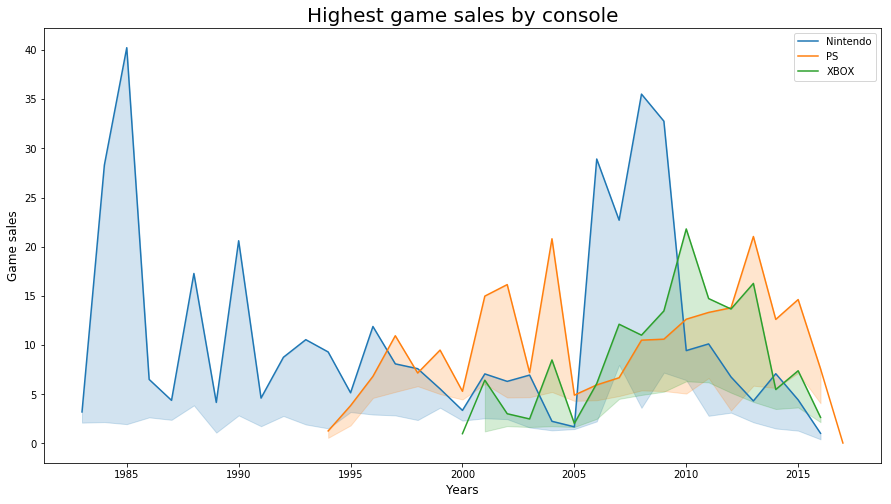

In [58]:
plt.figure(figsize=(15,8))
sns.lineplot(x='Year_of_Release',y='Global_Sales',data=df[df['Console_cluster']=='Nintendo'],estimator=np.max,label='Nintendo')
sns.lineplot(x='Year_of_Release',y='Global_Sales',data=df[df['Console_cluster']=='PS'],estimator=np.max,label='PS')
sns.lineplot(x='Year_of_Release',y='Global_Sales',data=df[df['Console_cluster']=='XBOX'],estimator=np.max,label='XBOX')
plt.title('Highest game sales by console', fontsize=20)
plt.ylabel("Game sales", fontsize=12)
plt.xlabel("Years", fontsize = 12)
plt.legend()

Conclusion for top games in a year:

We can see that Nintendo was one of the first game console developers, starting in 1983 with the NES. The first two years were booming as people discovered the gaming industry. Then, every two years a big game was released. From 1994, Playstation entered the market and overtook Nintendo after two years. In the period 2000, when the PS2 was released, Playstation was the big player in the market. However, in 2006 Nintendo came back with the famous Wii and took over the market since elder people also could play games. In the same time, XBox grew radidly and also overtook Playstation. However, when in 2013 the PS4 was launched, Playstation recovered ground.

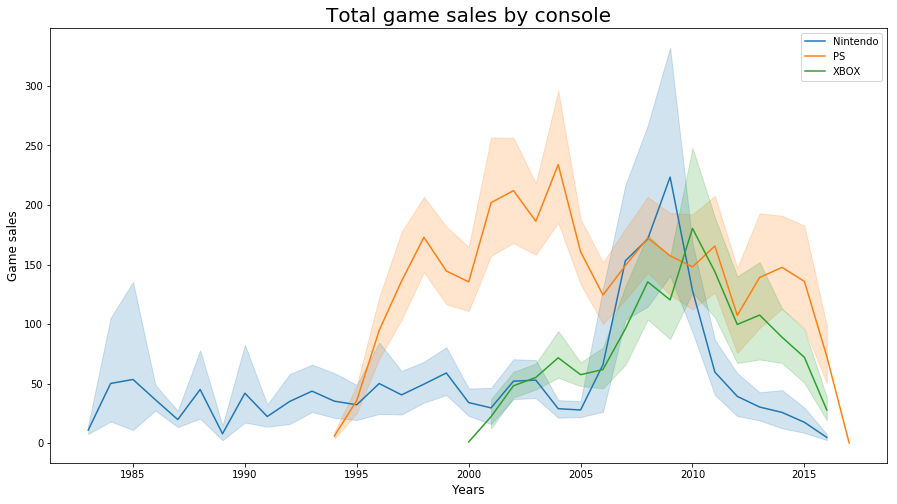

In [59]:
plt.figure(figsize=(15,8))
sns.lineplot(x='Year_of_Release',y='Global_Sales',data=df[df['Console_cluster']=='Nintendo'],estimator=sum,label='Nintendo')
sns.lineplot(x='Year_of_Release',y='Global_Sales',data=df[df['Console_cluster']=='PS'],estimator=sum,label='PS')
sns.lineplot(x='Year_of_Release',y='Global_Sales',data=df[df['Console_cluster']=='XBOX'],estimator=sum,label='XBOX')
plt.title('Total game sales by console', fontsize=20)
plt.ylabel("Game sales", fontsize=12)
plt.xlabel("Years", fontsize = 12)
plt.legend()

### Which continent has the most game sales?

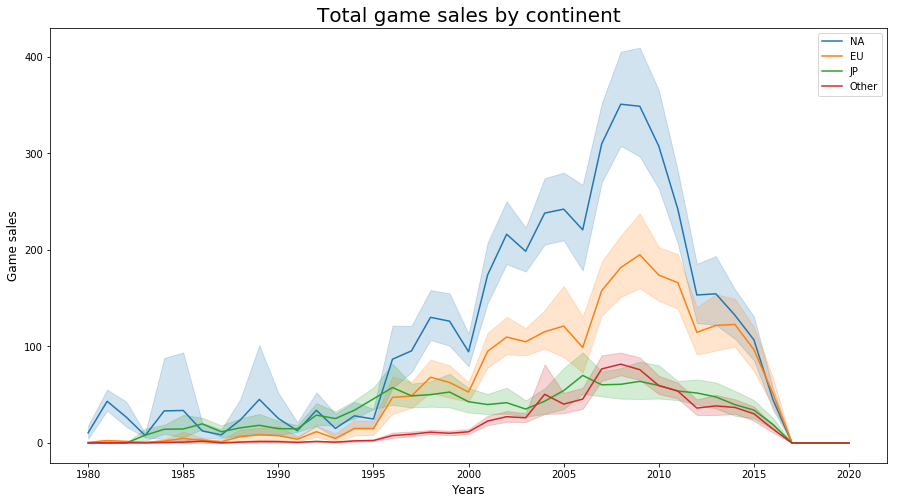

In [60]:
plt.figure(figsize=(15,8))
sns.lineplot(x='Year_of_Release',y='NA_Sales',data=df,estimator=sum,label='NA')
sns.lineplot(x='Year_of_Release',y='EU_Sales',data=df,estimator=sum,label='EU')
sns.lineplot(x='Year_of_Release',y='JP_Sales',data=df,estimator=sum,label='JP')
sns.lineplot(x='Year_of_Release',y='Other_Sales',data=df,estimator=sum,label='Other')
plt.title('Total game sales by continent', fontsize=20)
plt.ylabel("Game sales", fontsize=12)
plt.xlabel("Years", fontsize = 12)
plt.legend()

### Are children games sold better than adult games?

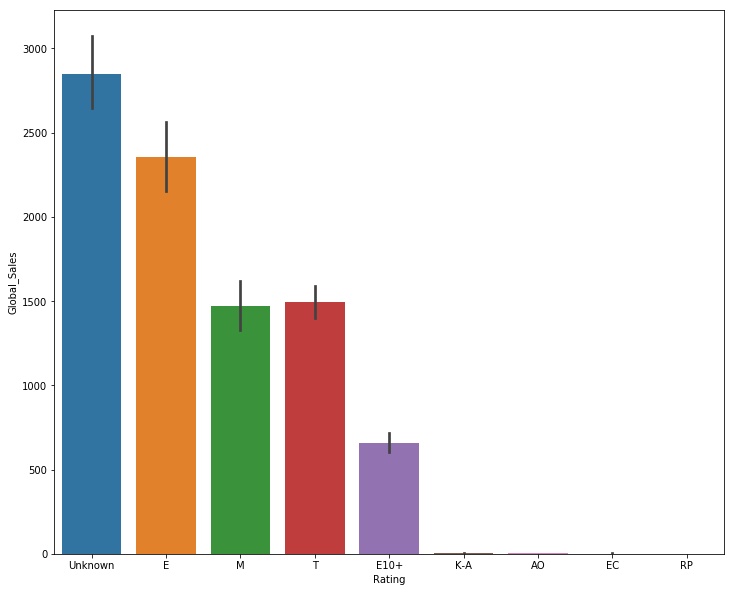

In [61]:
plt.figure(figsize=(12,10))
sns.barplot(x=df.Rating,y=df.Global_Sales, estimator=sum)

Text(0.5,0,'Years')

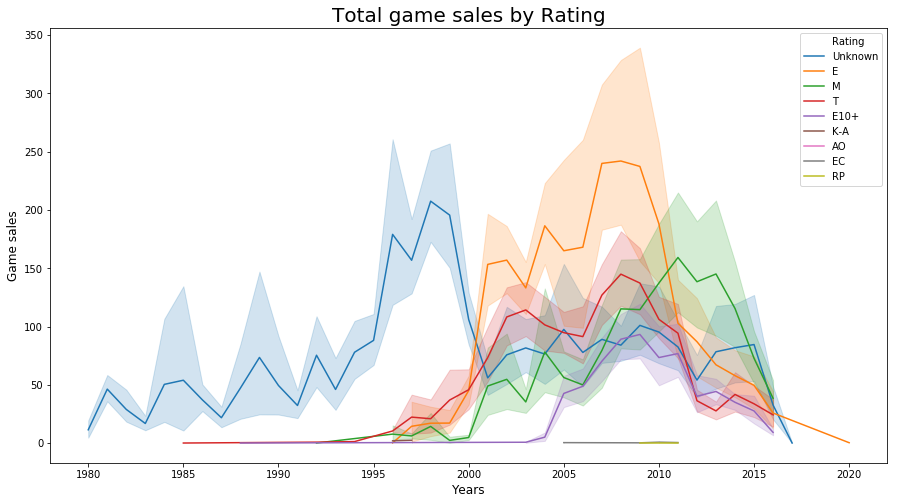

In [62]:
plt.figure(figsize=(15,8))
sns.lineplot(x='Year_of_Release',y='Global_Sales',data=df,estimator=sum,hue='Rating')
plt.title('Total game sales by Rating', fontsize=20)
plt.ylabel("Game sales", fontsize=12)
plt.xlabel("Years", fontsize = 12)

We last years, games rated as 'Mature' are more sold than 'Everyone'.

### Is there a correlation between the numerical features (critic score and user score) and the Global sales?

In [63]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Global_Sales_Log,NA_Sales_Log,EU_Sales_Log,JP_Sales_Log,Other_Sales_Log,Console_cluster
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,71,21,6.2,24,Unknown,3.719409,3.403860,1.521699,2.055405,0.570980,Nintendo
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82,73,8.3,709,E,3.597860,2.814210,2.621766,1.566530,1.456287,Nintendo
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80,73,8.0,192,E,3.519573,2.810005,2.479056,1.453953,1.373716,Nintendo
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,71,21,6.2,24,Unknown,3.477232,2.507157,2.291524,2.417698,0.693147,Other
5,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,71,21,6.2,24,Unknown,3.442339,3.186353,1.181727,1.652497,0.457425,Other


In [64]:
df.User_Score.dtype

dtype('float64')

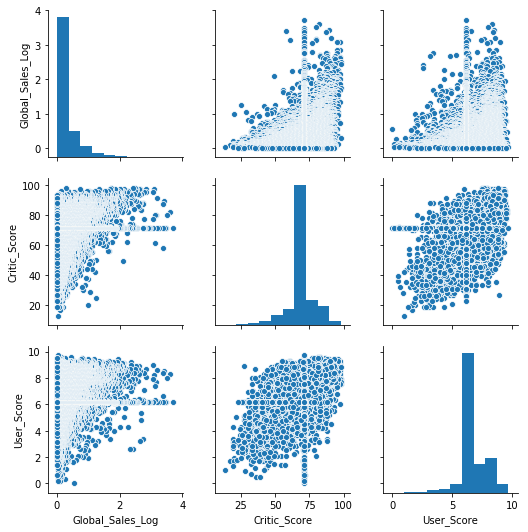

In [65]:
# Pairplot
sns.pairplot(df[['Global_Sales_Log','Critic_Score','User_Score']])

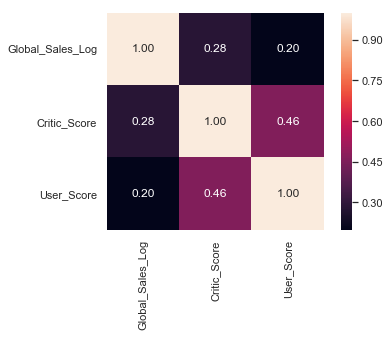

In [66]:
cm = np.corrcoef(df[['Global_Sales_Log','Critic_Score','User_Score']].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,fmt='.2f',yticklabels=['Global_Sales_Log','Critic_Score','User_Score'],xticklabels=['Global_Sales_Log','Critic_Score','User_Score'])

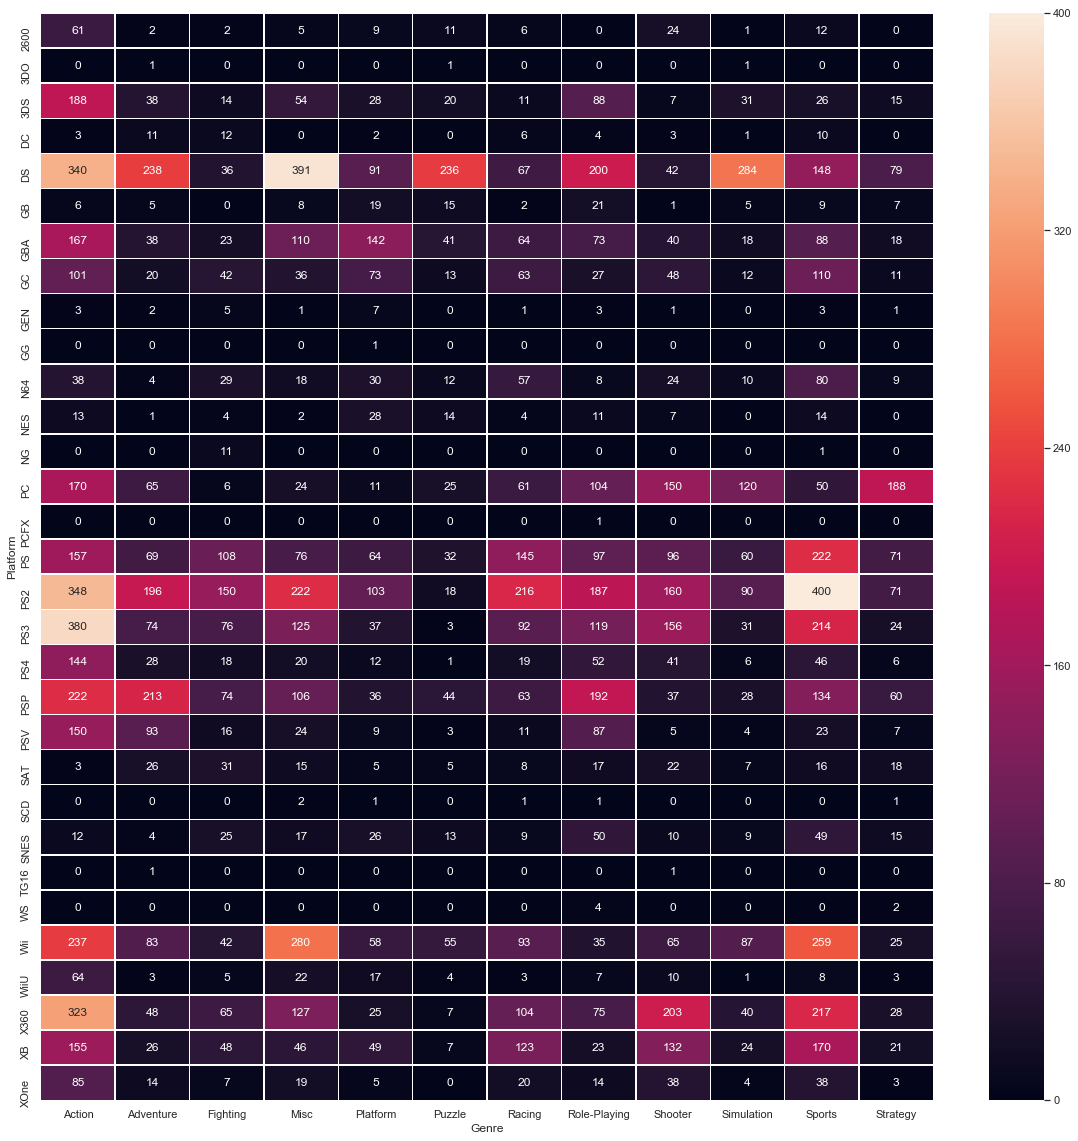

In [67]:
plt.figure(figsize=(20,20))
sns.heatmap(df.groupby(['Platform', 'Genre']).size().unstack(fill_value=0),annot=True,linewidths=.5,fmt='g')

### Categorical encoding and standardization 

First we will create a new feature, based on the year of release.
The new feature 'years_after_release' = year of release - release date of the platform

In [68]:
# Create new, empty column
df['year_after_release'] = ''

In [69]:
# Create variables for all console relese years
PS2_release = 2000
Wii_release = 2006
x2600_release = 1977
X360_release = 2005
GBA_release = 2001
PS3_release = 2006
PS_release = 1994
PSP_release = 2004
XB_release = 2001
GB_release = 1989
DS_release = 2004
x3DS_release = 2011
N64_release = 1996
PSV_release = 2011
GC_release = 2001

In [70]:
def year_after_release_filler(x):
    
        if x.Platform == 'PS2':
            return x.Year_of_Release - PS2_release 
        elif x.Platform == 'Wii':
            return x.Year_of_Release - Wii_release 
        elif x.Platform == '2600':
            return x.Year_of_Release - x2600_release 
        elif x.Platform == 'X360':
            return x.Year_of_Release - X360_release 
        elif x.Platform == 'GBA':
            return x.Year_of_Release - GBA_release 
        elif x.Platform == 'PS3':
            return x.Year_of_Release - PS3_release 
        elif x.Platform == 'PS':
            return x.Year_of_Release - PS_release 
        elif x.Platform == 'PSP':
            return x.Year_of_Release - PSP_release 
        elif x.Platform == 'XB':
            return x.Year_of_Release - XB_release 
        elif x.Platform == 'GB':
            return x.Year_of_Release - GB_release 
        elif x.Platform == 'DS':
            return x.Year_of_Release - DS_release 
        elif x.Platform == '3DS':
            return x.Year_of_Release - x3DS_release 
        elif x.Platform == 'N64':
            return x.Year_of_Release - N64_release 
        elif x.Platform == 'PSV':
            return x.Year_of_Release - PSV_release 
        elif x.Platform == 'GC':
            return x.Year_of_Release - GC_release 
        else:
            return 1

In [71]:
# apply function to replace values
df.year_after_release = df.apply(year_after_release_filler, axis=1)

In [72]:
df[df['year_after_release'] <0]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Global_Sales_Log,NA_Sales_Log,EU_Sales_Log,JP_Sales_Log,Other_Sales_Log,Console_cluster,year_after_release
1340,Disney's DuckTales,GB,1988,Platform,Other,0.82,0.23,0.35,0.03,1.43,71,21,6.2,24,Unknown,0.887891,0.598837,0.207014,0.300105,0.029559,Other,-1
2076,NFL Fever 2002,XB,2000,Sports,Other,0.74,0.21,0.00,0.04,0.99,79,24,8.5,10,E,0.688135,0.553885,0.190620,0.000000,0.039221,XBOX,-1
12301,ESPN Winter X-Games: Snowboarding 2002,GBA,2000,Sports,Konami Digital Entertainment,0.05,0.02,0.00,0.00,0.06,71,21,6.2,24,Unknown,0.058269,0.048790,0.019803,0.000000,0.000000,Other,-1
15959,Strongest Tokyo University Shogi DS,DS,1985,Action,Other,0.00,0.00,0.02,0.00,0.02,71,21,6.2,24,Unknown,0.019803,0.000000,0.000000,0.019803,0.000000,Other,-19


We can see that four instances are not correct. We will drop index 15959. The other 3, we will change the -1 to 0.

In [73]:
df.drop(index=[15959],inplace=True)

In [74]:
df[df['year_after_release'] <0]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Global_Sales_Log,NA_Sales_Log,EU_Sales_Log,JP_Sales_Log,Other_Sales_Log,Console_cluster,year_after_release
1340,Disney's DuckTales,GB,1988,Platform,Other,0.82,0.23,0.35,0.03,1.43,71,21,6.2,24,Unknown,0.887891,0.598837,0.207014,0.300105,0.029559,Other,-1
2076,NFL Fever 2002,XB,2000,Sports,Other,0.74,0.21,0.00,0.04,0.99,79,24,8.5,10,E,0.688135,0.553885,0.190620,0.000000,0.039221,XBOX,-1
12301,ESPN Winter X-Games: Snowboarding 2002,GBA,2000,Sports,Konami Digital Entertainment,0.05,0.02,0.00,0.00,0.06,71,21,6.2,24,Unknown,0.058269,0.048790,0.019803,0.000000,0.000000,Other,-1


In [75]:
df.year_after_release.loc[[1340, 2076, 12301]] = 0

In [76]:
# Drop the original Year_of_Release column
df.drop('Year_of_Release',axis=1,inplace=True)

### Encoding categorical features 

We will now create dummy variables for Platform, Genre, Publisher and Rating.

In [77]:
df_dummies = pd.get_dummies(df[['Platform','Genre','Publisher','Rating']], drop_first = True)
# Merge the dummies dataframe with the original dataframe
df = pd.merge(df_dummies, df, left_index=True, right_index=True)

In [78]:
# Drop original columns
df.drop(['Name','Platform','Genre','Publisher','Rating','Console_cluster'],axis=1, inplace=True)

In [79]:
df.head()

,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_GG,Platform_N64,Platform_NES,Platform_NG,Platform_PC,Platform_PCFX,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Publisher_Electronic Arts,Publisher_Konami Digital Entertainment,Publisher_Namco Bandai Games,Publisher_Nintendo,Publisher_Other,Publisher_Sega,Publisher_Sony Computer Entertainment,Publisher_THQ,Publisher_Take-Two Interactive,Publisher_Ubisoft,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T,Rating_Unknown,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Global_Sales_Log,NA_Sales_Log,EU_Sales_Log,JP_Sales_Log,Other_Sales_Log,year_after_release
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,29.08,3.58,6.81,0.77,40.24,71,21,6.2,24,3.719409,3.403860,1.521699,2.055405,0.570980,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,15.68,12.76,3.79,3.29,35.52,82,73,8.3,709,3.597860,2.814210,2.621766,1.566530,1.456287,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,15.61,10.93,3.28,2.95,32.77,80,73,8.0,192,3.519573,2.810005,2.479056,1.453953,1.373716,3
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11.27,8.89,10.22,1.00,31.37,71,21,6.2,24,3.477232,2.507157,2.291524,2.417698,0.693147,7
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,23.20,2.26,4.22,0.58,30.26,71,21,6.2,24,3.442339,3.186353,1.181727,1.652497,0.457425,0


### Standardizing numerical features 

User_Score features that need to be standardized are: Critic_Score, Critic_Count, User_Count, year_after_release

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [81]:
scaled_features = scaler.fit_transform(df[['Critic_Score', 'Critic_Count','User_Score','User_Count','year_after_release']])
scaled_df = pd.DataFrame(scaled_features, columns=['Critic_Score', 'Critic_Count','User_Score','User_Count','year_after_release'])

In [82]:
# Merge scaled_df with normal df on index
df = pd.merge(scaled_df, df, left_index=True, right_index=True)

In [83]:
# Drop original non-standardized features
columns = ['Critic_Score_y', 'Critic_Count_y','User_Score_y','User_Count_y','NA_Sales', 'EU_Sales','JP_Sales','Other_Sales','Global_Sales','year_after_release_y']
df.drop(columns, inplace=True, axis=1)

# Split training-test data

For the first ML models, we will use 'Global_Sales_Log' as the target variable.

In [84]:
X = df.drop(['Global_Sales_Log','NA_Sales_Log','EU_Sales_Log','JP_Sales_Log','Other_Sales_Log'], axis=1)
y = df['Global_Sales_Log']

# Learning and evaluation

In [85]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

Regressor algorithms to test:

1. LinearRegression

2. Ridge

3. DecisionTreeRegressor

4. RandomForestRegressor

5. AdaBoost Regressor 

6. XGBoost

## 1. Linear Regression

In [87]:
from sklearn.linear_model import LinearRegression

In [88]:
lr = LinearRegression()

In [89]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [90]:
lr_predictions = lr.predict(X_test)

In [91]:
# Evaluate model
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error

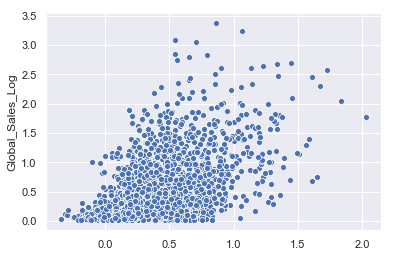

In [92]:
sns.scatterplot(lr_predictions,y_test)

In [93]:
MAE_lr = mean_absolute_error(y_test, lr_predictions)
MSE_lr = mean_squared_error(y_test, lr_predictions)
var_lr = explained_variance_score(y_test, lr_predictions)

In [94]:
print("MAE :" + str(MAE_lr))
print("MSE :" + str(MSE_lr))
print("Explained variance :" + str(var_lr))

MAE :0.21003531432026848
MSE :0.10153305710633657
Explained variance :0.34420925684781467


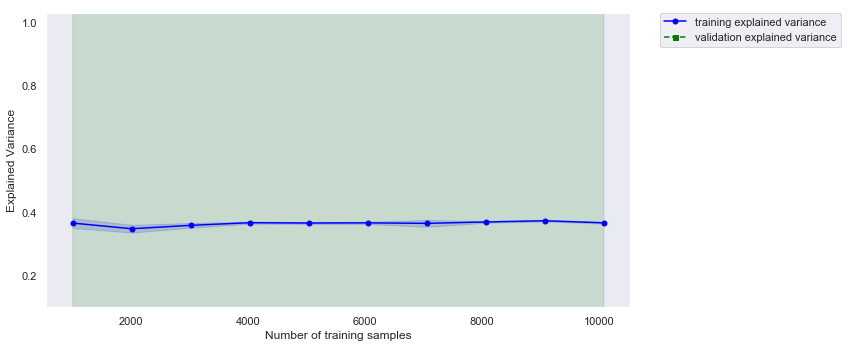

In [95]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,scoring = 'explained_variance',
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training explained variance')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation explained variance')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Explained Variance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0.1, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

## 2. Ridge Regression 

In [96]:
from sklearn.linear_model import Ridge

In [97]:
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=10, verbose=1, scoring = 'explained_variance')
grid_ridge.fit(X_train, y_train)

print(grid_ridge.best_score_)
print(grid_ridge.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
0.3563235529216164
{'alpha': 1, 'normalize': False, 'tol': 1e-06}


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   21.0s finished


In [118]:
ridge_optimized = Ridge(alpha= 1, normalize= False, tol=1e-06)

In [119]:
ridge_optimized.fit(X_train,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=1e-06)

In [120]:
ridge_pred = ridge_optimized.predict(X_test)

In [121]:
MAE_ridge = mean_absolute_error(y_test, ridge_pred)
MSE_ridge = mean_squared_error(y_test, ridge_pred)
var_ridge = explained_variance_score(y_test, ridge_pred)

In [122]:
print("MAE :" + str(MAE_ridge))
print("MSE :" + str(MSE_ridge))
print("Explained variance :" + str(var_ridge))

MAE :0.2099979948955831
MSE :0.10152769680712226
Explained variance :0.34424596635984006


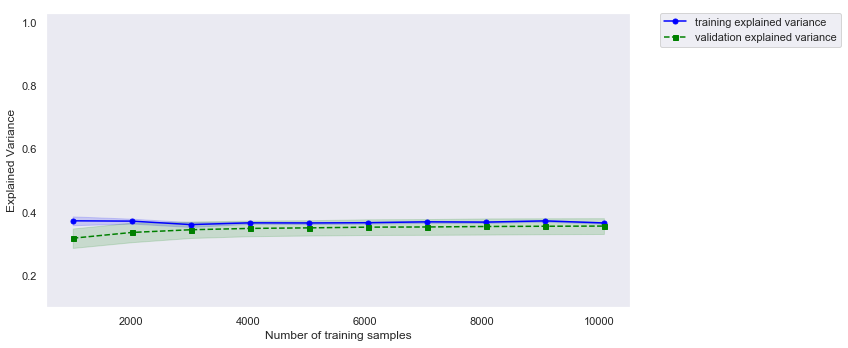

In [123]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=ridge_optimized,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,scoring = 'explained_variance',
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training explained variance')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation explained variance')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Explained Variance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0.1, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

## 3. RandomForest Regression 

In [98]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
rf = RandomForestRegressor()

In [100]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [101]:
rf_predictions = rf.predict(X_test)

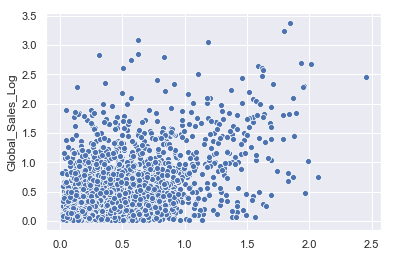

In [102]:
sns.scatterplot(rf_predictions,y_test)

In [103]:
MAE_rf = mean_absolute_error(y_test, rf_predictions)
MSE_rf = mean_squared_error(y_test, rf_predictions)
var_rf = explained_variance_score(y_test, rf_predictions)

In [104]:
print("MAE :" + str(MAE_rf))
print("MSE :" + str(MSE_rf))
print("Explained variance :" + str(var_rf))

MAE :0.20710525535035676
MSE :0.1053968120646806
Explained variance :0.31978303565798505


In [105]:
# Random Hyperparameter Grid
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [106]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 47.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [107]:
print(rf_random.best_score_)
print(rf_random.best_params_)

0.42461793866987424
{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [108]:
rf_optimized = RandomForestRegressor(n_estimators=800,min_samples_split=10, min_samples_leaf=2, max_features='sqrt',max_depth=30,bootstrap=False)

In [109]:
rf_optimized.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [110]:
rf_pred = rf_optimized.predict(X_test)

In [112]:
MAE_rf = mean_absolute_error(y_test, rf_pred)
MSE_rf = mean_squared_error(y_test, rf_pred)
var_rf = explained_variance_score(y_test, rf_pred)

In [113]:
print("MAE :" + str(MAE_rf))
print("MSE :" + str(MSE_rf))
print("Explained variance :" + str(var_rf))

MAE :0.18949053773942384
MSE :0.0890810567121889
Explained variance :0.42457155520554557


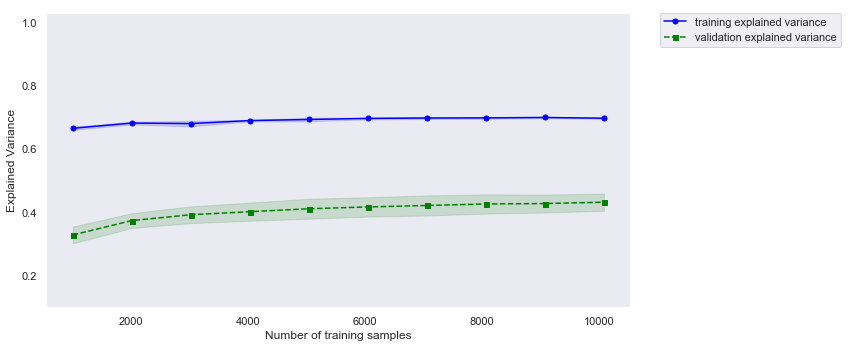

In [114]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=rf_optimized,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,scoring = 'explained_variance',
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training explained variance')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation explained variance')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Explained Variance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0.1, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

## 4. Neural Network (TensorFlow)

In [134]:
import tensorflow as tf
from tensorflow import keras

In [137]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________


In [139]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

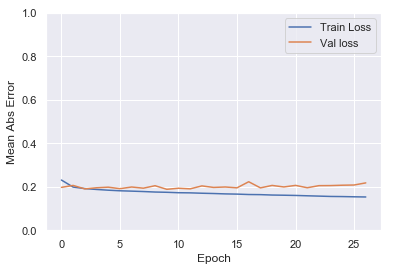

In [166]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 1])

plot_history(history)

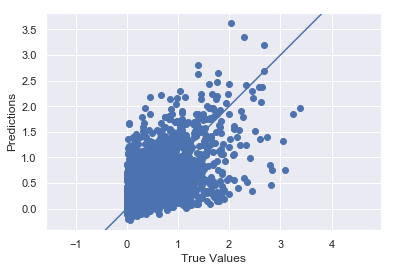

In [165]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

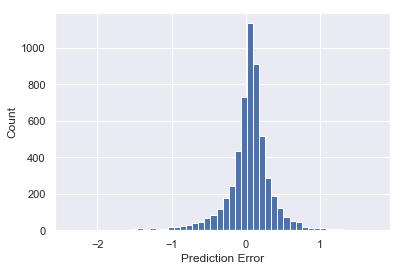

In [152]:
error = test_predictions - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [149]:
MAE_NN = mean_absolute_error(y_test, test_predictions)
MSE_NN = mean_squared_error(y_test, test_predictions)
var_NN = explained_variance_score(y_test, test_predictions)

In [151]:
print("MAE :" + str(MAE_NN))
print("MSE :" + str(MSE_NN))
print("Explained variance :" + str(var_NN))

MAE :0.21963126574291592
MSE :0.11050639158050465
Explained variance :0.2989288798019263


## 5. XGBoosting 

In [153]:
import xgboost

In [154]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [159]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [160]:
xgb_pred = xgb.predict(X_test)

In [161]:
MAE_xgb = mean_absolute_error(y_test, xgb_pred)
MSE_xgb = mean_squared_error(y_test, xgb_pred)
var_xgb = explained_variance_score(y_test, xgb_pred)

In [162]:
print("MAE :" + str(MAE_xgb))
print("MSE :" + str(MSE_xgb))
print("Explained variance :" + str(var_xgb))

MAE :0.18618445368734804
MSE :0.0883080921709491
Explained variance :0.4295864556033031


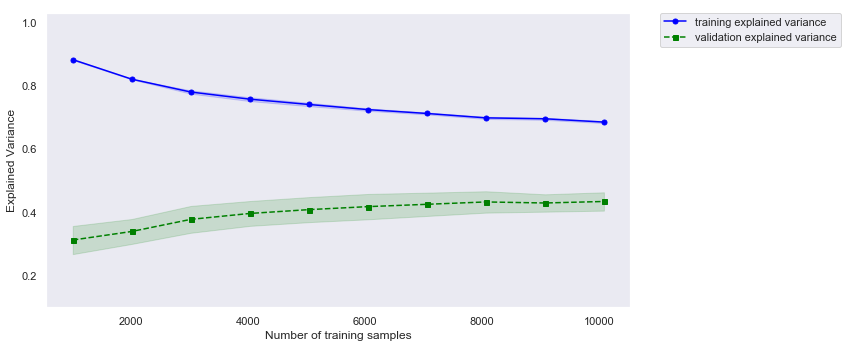

In [163]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=xgb,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,scoring = 'explained_variance',
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training explained variance')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation explained variance')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Explained Variance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0.1, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

# Evaluate different models

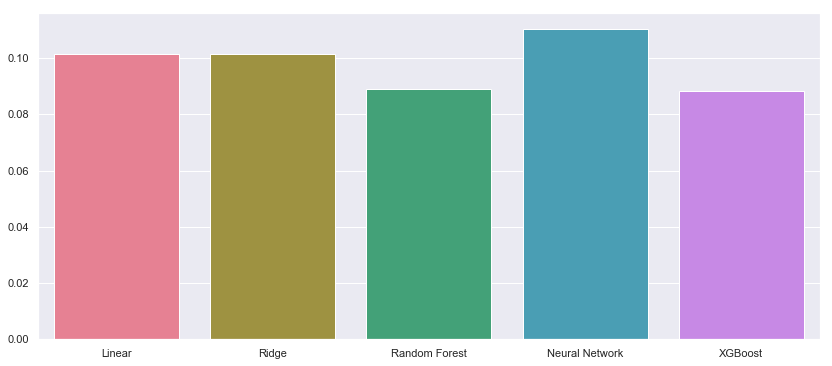

In [164]:
# Comparison of MSE of the models
MSEs = [MSE_lr,MSE_ridge,MSE_rf,MSE_NN,MSE_xgb]
models = ['Linear','Ridge','Random Forest','Neural Network','XGBoost']
plt.figure(figsize=(14,6))
sns.barplot(models,MSEs,palette='husl')

From the barplot, we can see that XGBoosting performs best on this dataset. 